In [1]:
!pip install -q -U mdai

     |████████████████████████████████| 266 kB 4.3 MB/s 
     |████████████████████████████████| 64 kB 2.4 MB/s 
     |████████████████████████████████| 2.0 MB 44.0 MB/s 


In [2]:
import mdai

In [4]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="fe2a15a755129ab880dece93ef01b96f")
p = mdai_client.project('aGq4k6NW', path='./lesson2-data')

Successfully authenticated to public.md.ai.
Using path './lesson2-data' for data.
Preparing annotations export for project aGq4k6NW...                                                
Preparing images export for project aGq4k6NW...                                                     


3.75MB [00:00, 135MB/s]                    


Success: annotations data for project aGq4k6NW ready.


11.4MB [00:00, 13.3MB/s]                            


Extracting archive: mdai_public_project_aGq4k6NW_images_2021-04-20-155137.zip
Success: images data for project aGq4k6NW ready.


In [5]:
# this maps label ids to class ids as a dict obj
labels_dict = {
    'L_A8Jm3d': 1, # Lung   
}
p.set_labels_dict(labels_dict)

In [6]:
p.show_datasets() 

Datasets:
Id: D_rQLwzo, Name: Dataset



In [7]:
dataset = p.get_dataset_by_id('D_rQLwzo')
dataset.prepare()
image_ids = dataset.get_image_ids()

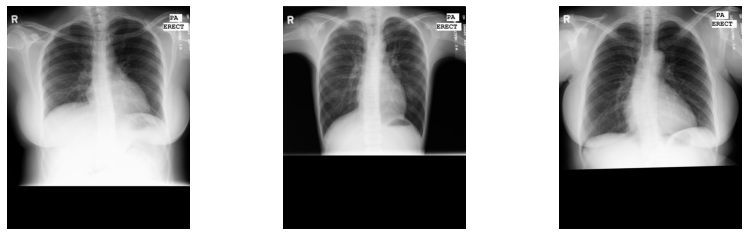

In [8]:
mdai.visualize.display_images(image_ids[:3], cols=3)

In [9]:
import tensorflow as tf

In [10]:
!pip install -q keras-unet

In [11]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [12]:
imgs_anns_dict = dataset.imgs_anns_dict

In [13]:
def load_images(imgs_anns_dict, img_size=128):
    images = []
    masks = []

    for img_fp in imgs_anns_dict.keys():
        img = mdai.visualize.load_dicom_image(img_fp)
        ann = imgs_anns_dict[img_fp]

        img_width = img.shape[1]
        img_height = img.shape[0]

        mask = np.zeros((img_height, img_width), dtype=np.uint8)

        assert img.shape == mask.shape

        for a in ann:
            vertices = np.array(a['data']['vertices'])
            vertices = vertices.reshape((-1, 2))
            cv2.fillPoly(mask, np.int32([vertices]), (255, 255, 255))

        # resizing and padding
        if img.shape[0] == img.shape[1]:
            resized_shape = (img_size, img_size)
            offset = (0, 0)

        # height > width
        elif img.shape[0] > img.shape[1]:
            resized_shape = (img_size, round(img_size * img.shape[1] / img.shape[0]))
            offset = (0, (img_size - resized_shape[1]) // 2)

        else:
            resized_shape = (round(img_size * img.shape[0] / img.shape[1]), img_size)
            offset = ((img_size - resized_shape[0]) // 2, 0)

        resized_shape = (resized_shape[1], resized_shape[0])
        img_resized = cv2.resize(img, resized_shape).astype(np.uint8)
        mask_resized = cv2.resize(mask, resized_shape).astype(np.bool)

        resized_shape = (resized_shape[1], resized_shape[0])

        # add padding to square
        img_padded = np.zeros((img_size, img_size), dtype=np.uint8)
        img_padded[
            offset[0] : (offset[0] + resized_shape[0]), offset[1] : (offset[1] + resized_shape[1])
        ] = img_resized
        mask_padded = np.zeros((img_size, img_size), dtype=np.bool)
        mask_padded[
            offset[0] : (offset[0] + resized_shape[0]), offset[1] : (offset[1] + resized_shape[1])
        ] = mask_resized

        images.append(img_padded)
        masks.append(mask_padded)

    # add channel dim
    images = np.asarray(images)[:, :, :, None]
    masks = np.asarray(masks)[:, :, :, None]
    return images, masks

In [14]:
images, masks = load_images(imgs_anns_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [16]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=0)

In [17]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=8,
    data_gen_args = dict(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
    ))

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [18]:
from keras_unet.models import custom_unet

model = custom_unet(
    x_train[0].shape,
    use_batch_norm=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid',
)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
    ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
]

In [20]:
from tensorflow.keras.optimizers import Adam
from keras_unet.metrics import iou

model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy', iou],
)

In [21]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9274 - iou: 0.6130
Epoch 1: val_loss improved from inf to 2.55384, saving model to model.h5
100/100 [==============================] - 66s 436ms/step - loss: 0.1833 - accuracy: 0.9274 - iou: 0.6130 - val_loss: 2.5538 - val_accuracy: 0.8065 - val_iou: 0.4560
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9589 - iou: 0.7867
Epoch 2: val_loss improved from 2.55384 to 0.25155, saving model to model.h5
100/100 [==============================] - 34s 342ms/step - loss: 0.0781 - accuracy: 0.9589 - iou: 0.7867 - val_loss: 0.2516 - val_accuracy: 0.9427 - val_iou: 0.7340
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 0.9628 - iou: 0.8279
Epoch 3: val_loss did not improve from 0.25155
100/100 [==============================] - 33s 328ms/step - loss: 0.0632 - accuracy: 0.9628 - iou: 0.8279 - val_loss: 0.2549 - val_accuracy: 

In [22]:
test_eval = model.evaluate( x_val,y_val, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.0742504820227623
Test accuracy: 0.9772142767906189


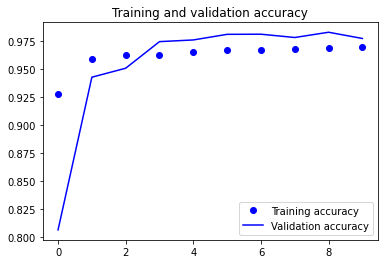

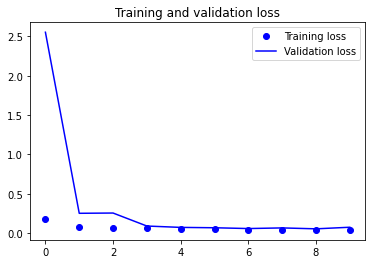

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

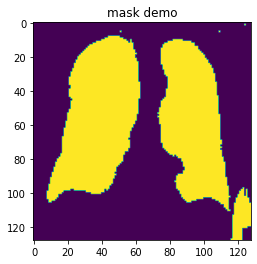

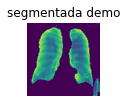

In [ ]:
import os
DATADIR = 'E:\\Users\\gcmor\\Documentos\\CURSOS\\IA\\datasets\\COVID-19_Radiography_Dataset'
CATEGORIES = ["Normal"]
path = os.path.join(DATADIR,"COVID")
img = cv2.imread(os.path.join(path,'COVID-400.png'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = cv2.resize(img, (256, 256))

img_width = img.shape[1]
img_height = img.shape[0]

img_size = 128
resized_shape = (img_size, img_size)
offset = (0, 0)

resized_shape = (resized_shape[1], resized_shape[0])
img_resized = cv2.resize(img, resized_shape).astype(np.uint8)

resized_shape = (resized_shape[1], resized_shape[0])

# add padding to square
img_padded = np.zeros((img_size, img_size), dtype=np.uint8)
img_padded[
    offset[0] : (offset[0] + resized_shape[0]), offset[1] : (offset[1] + resized_shape[1])
] = img_resized

random_img = img_padded
random_img_2 = np.expand_dims(np.expand_dims(random_img, axis=0), axis=3)

mask = model.predict(random_img_2)[0][:,:,0] > 0.5

plt.imshow(mask)
plt.title('mask demo')
plt.show()

plt.subplot(1,4,4)
plt.imshow(cv2.bitwise_and(random_img, random_img, mask=mask.astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Lung Segmentation')

plt.imshow(cv2.bitwise_and(random_img, random_img, mask=mask.astype(np.uint8)))
plt.title('segmentada demo')
plt.show()

